In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
df = pd.read_csv("../data/raw/River_Arno.csv")
df.head()

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,01/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1,02/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
2,03/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
3,04/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84
4,05/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88


In [4]:
df.shape

(8217, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8217 entries, 0 to 8216
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8217 non-null   object 
 1   Rainfall_Le_Croci          6026 non-null   float64
 2   Rainfall_Cavallina         6026 non-null   float64
 3   Rainfall_S_Agata           6026 non-null   float64
 4   Rainfall_Mangona           6026 non-null   float64
 5   Rainfall_S_Piero           6026 non-null   float64
 6   Rainfall_Vernio            4283 non-null   float64
 7   Rainfall_Stia              1283 non-null   float64
 8   Rainfall_Consuma           1283 non-null   float64
 9   Rainfall_Incisa            4568 non-null   float64
 10  Rainfall_Montevarchi       1647 non-null   float64
 11  Rainfall_S_Savino          1283 non-null   float64
 12  Rainfall_Laterina          1283 non-null   float64
 13  Rainfall_Bibbiena          2378 non-null   float

In [6]:
#Convertimos la columna date a formato datetime. No lo ponemos como indice porque Prophet lo requiere como columna.
df["Date"] = pd.to_datetime(df["Date"], format = '%d/%m/%Y')

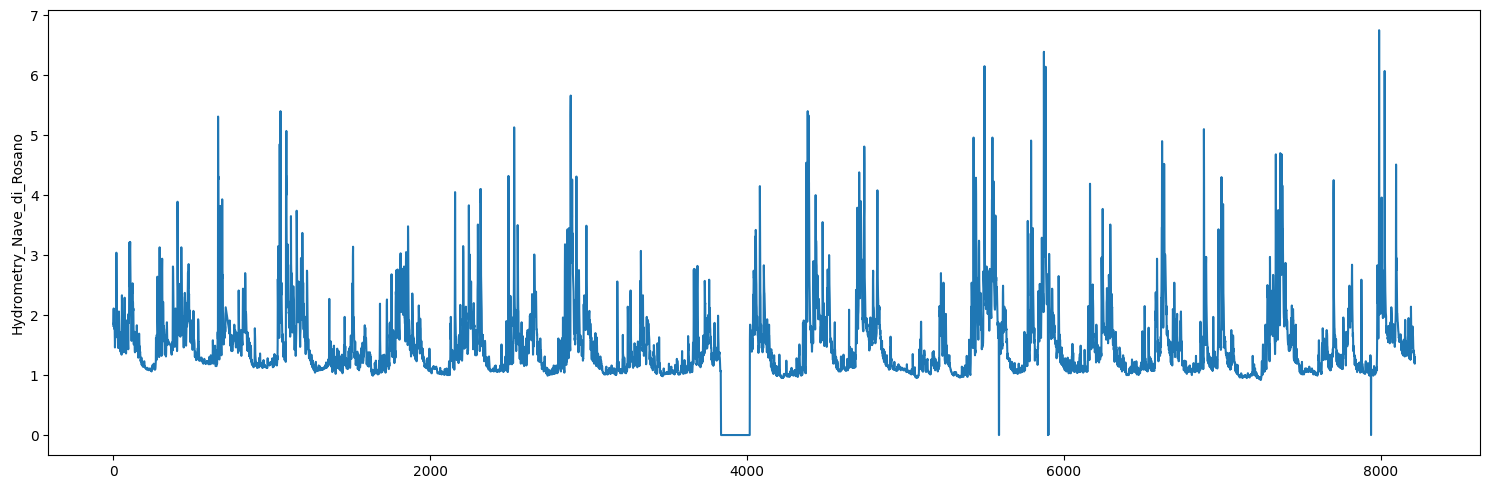

In [7]:
#Visualizamos la variable objetivo de la serie temporal
fig, axis = plt.subplots(figsize = (15, 5))
sns.lineplot(data = df["Hydrometry_Nave_di_Rosano"])
plt.tight_layout()
plt.show()

# Preprocesamiento

In [8]:
#Cantidad de NaN
cantidad_nan = df.isna().sum()
print("Cantidad de NaN:")
print(cantidad_nan)

Cantidad de NaN:
Date                            0
Rainfall_Le_Croci            2191
Rainfall_Cavallina           2191
Rainfall_S_Agata             2191
Rainfall_Mangona             2191
Rainfall_S_Piero             2191
Rainfall_Vernio              3934
Rainfall_Stia                6934
Rainfall_Consuma             6934
Rainfall_Incisa              3649
Rainfall_Montevarchi         6570
Rainfall_S_Savino            6934
Rainfall_Laterina            6934
Rainfall_Bibbiena            5839
Rainfall_Camaldoli           6934
Temperature_Firenze          2025
Hydrometry_Nave_di_Rosano      48
dtype: int64


In [9]:
#Trabajaremos con las columnas que tengan mas de la mitad de los datos
df = df.loc[:, df.isnull().mean() < 0.5]
df.head()

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Incisa,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,1998-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1,1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
2,1998-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
3,1998-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84
4,1998-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88


In [11]:
# No puede haber valores 0 en la variable objetivo, los eliminamos
df['Hydrometry_Nave_di_Rosano'] = df['Hydrometry_Nave_di_Rosano'].replace(0, np.nan)

In [12]:
#Eliminamos las filas con NaN en la variable objetivo
df = df.dropna(subset=['Hydrometry_Nave_di_Rosano'])

In [13]:
# Renombramos las columnas para Prophet
df = df.rename(columns={'Date': 'ds', 'Hydrometry_Nave_di_Rosano': 'y'})

In [14]:
# Imputamos los valores faltantes de las demas columnas con la mediana
df['Rainfall_Le_Croci'] = df['Rainfall_Le_Croci'].fillna(df['Rainfall_Le_Croci'].median())
df['Rainfall_Cavallina'] = df['Rainfall_Cavallina'].fillna(df['Rainfall_Cavallina'].median())
df['Rainfall_S_Agata'] = df['Rainfall_S_Agata'].fillna(df['Rainfall_S_Agata'].median())
df['Rainfall_Mangona'] = df['Rainfall_Mangona'].fillna(df['Rainfall_Mangona'].median())
df['Rainfall_S_Piero'] = df['Rainfall_S_Piero'].fillna(df['Rainfall_S_Piero'].median())
df['Rainfall_Vernio'] = df['Rainfall_Vernio'].fillna(df['Rainfall_Vernio'].median())
df['Rainfall_Incisa'] = df['Rainfall_Incisa'].fillna(df['Rainfall_Incisa'].median())
df['Temperature_Firenze'] = df['Temperature_Firenze'].fillna(df['Temperature_Firenze'].median())

# EDA

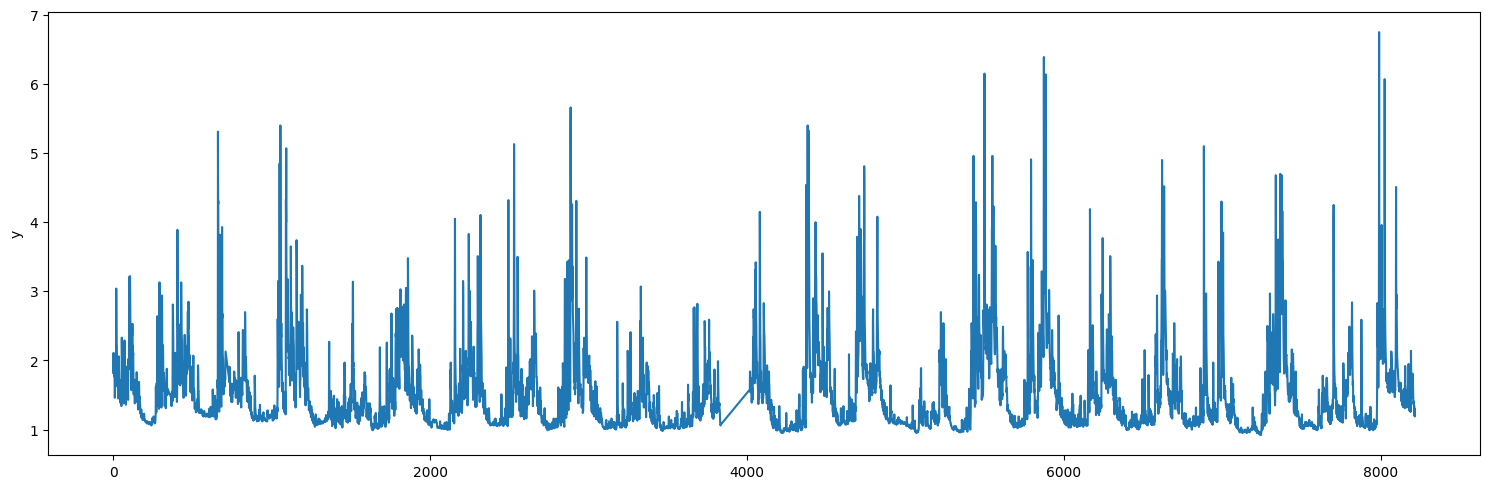

In [15]:
fig, axis = plt.subplots(figsize = (15, 5))
sns.lineplot(data = df["y"])
plt.tight_layout()
plt.show()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

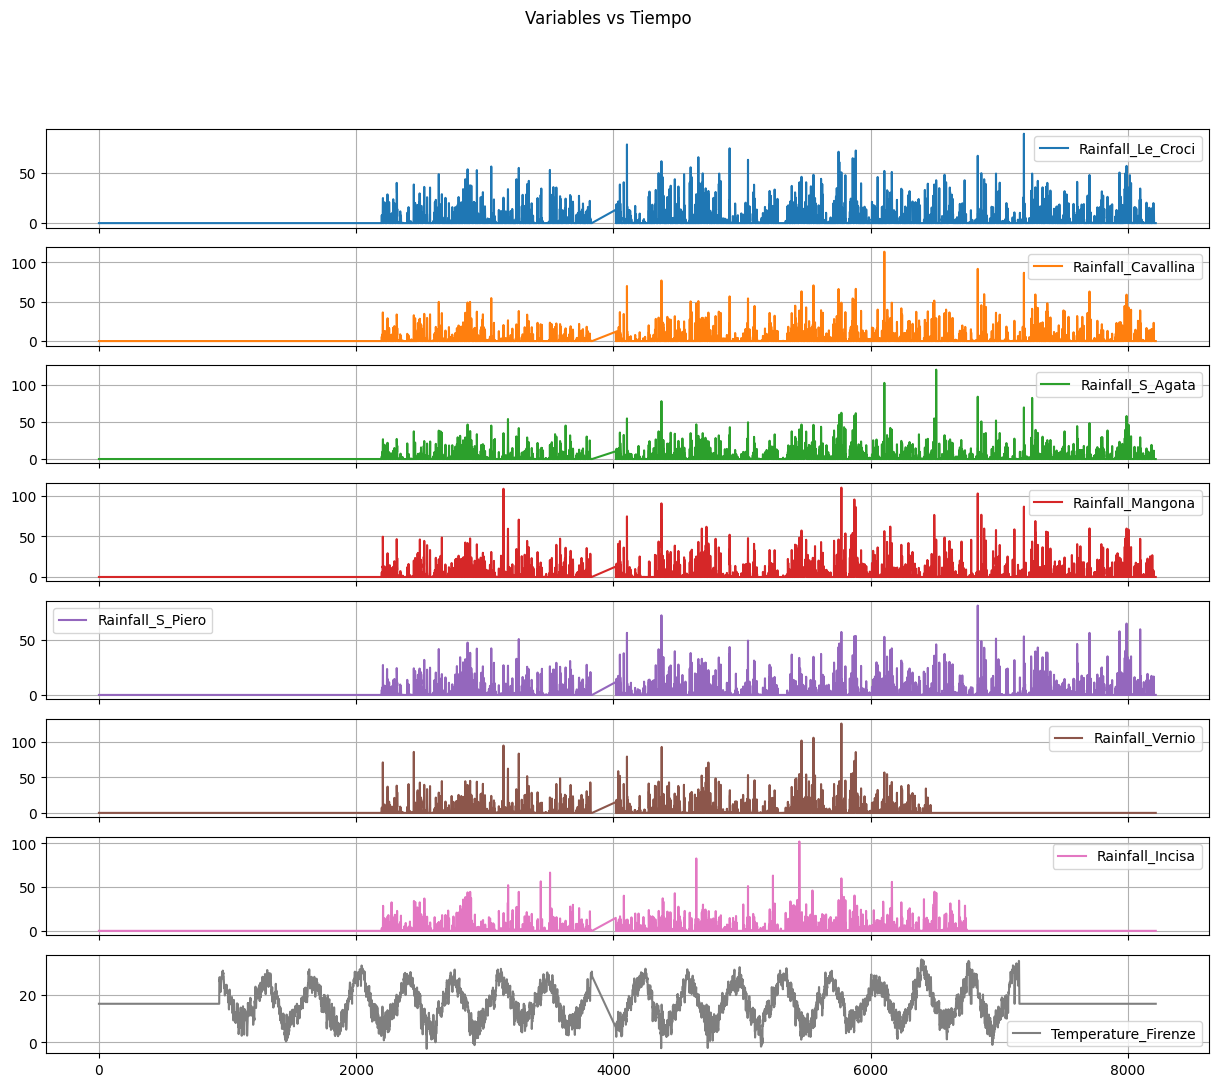

In [17]:
df[['Rainfall_Le_Croci', 'Rainfall_Cavallina',
    'Rainfall_S_Agata', 'Rainfall_Mangona', 'Rainfall_S_Piero',
    'Rainfall_Vernio', 'Rainfall_Incisa', 'Temperature_Firenze']] \
    .plot(subplots=True, figsize=(15, 12), title='Variables vs Tiempo', grid=True)

In [18]:
# Crear lag de 1 dia y eliminamos los valores nulos
df['lag_1'] = df['y'].shift(1)
df = df.dropna(subset=['lag_1'])

In [19]:
# Creamos lag de 1 dia para la variable de lluvia y eliminamos los valores nulos
df['rainfall_1'] = df['Rainfall_Le_Croci'].shift(1)
df = df.dropna(subset=['rainfall_1'])

# Análisis de la serie temporal

### Descomposicion

In [20]:
decomposition = seasonal_decompose(df['y'], model='additive', period=365)
decomposition

### Análisis de la tendencia

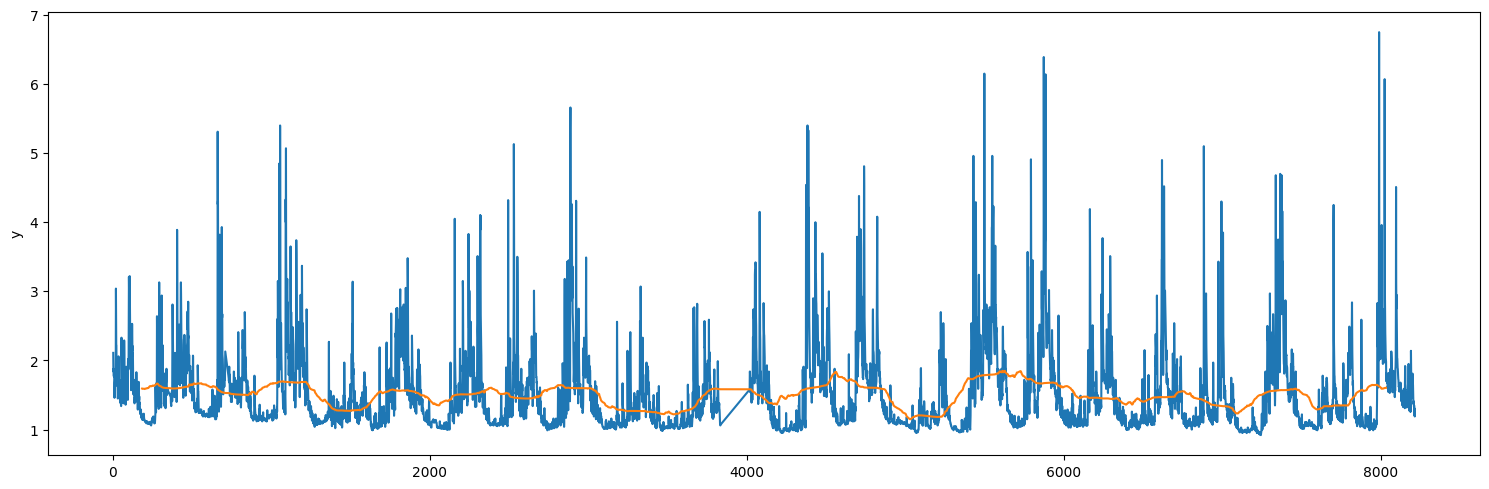

In [21]:
trend = decomposition.trend
fig, axis = plt.subplots(figsize = (15, 5))

sns.lineplot(data = df['y'])
sns.lineplot(data = trend)

plt.tight_layout()
plt.show()

### Análisis de la estacionalidad

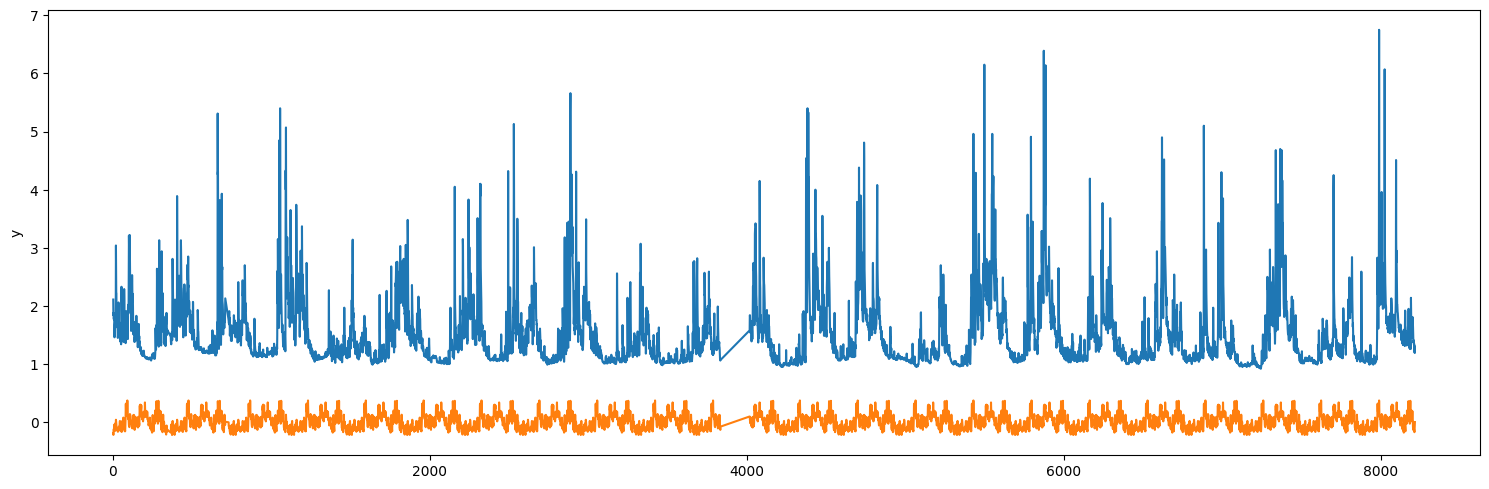

In [22]:
seasonal = decomposition.seasonal
fig, axis = plt.subplots(figsize = (15, 5))

sns.lineplot(data = df['y'])
sns.lineplot(data = seasonal)

plt.tight_layout()
plt.show()

In [23]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df['y'])

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -8.002421e+00
p-value                        2.314841e-12
#Lags Used                     3.600000e+01
Number of Observations Used    7.943000e+03
Critical Value (1%)           -3.431174e+00
Critical Value (5%)           -2.861904e+00
Critical Value (10%)          -2.566964e+00
dtype: float64

In [24]:
print("La serie es estacionaria porque el p-valor es menor a 0.05. (practicamente 0)")

La serie es estacionaria porque el p-valor es menor a 0.05. (practicamente 0)


### Análisis de la variabilidad

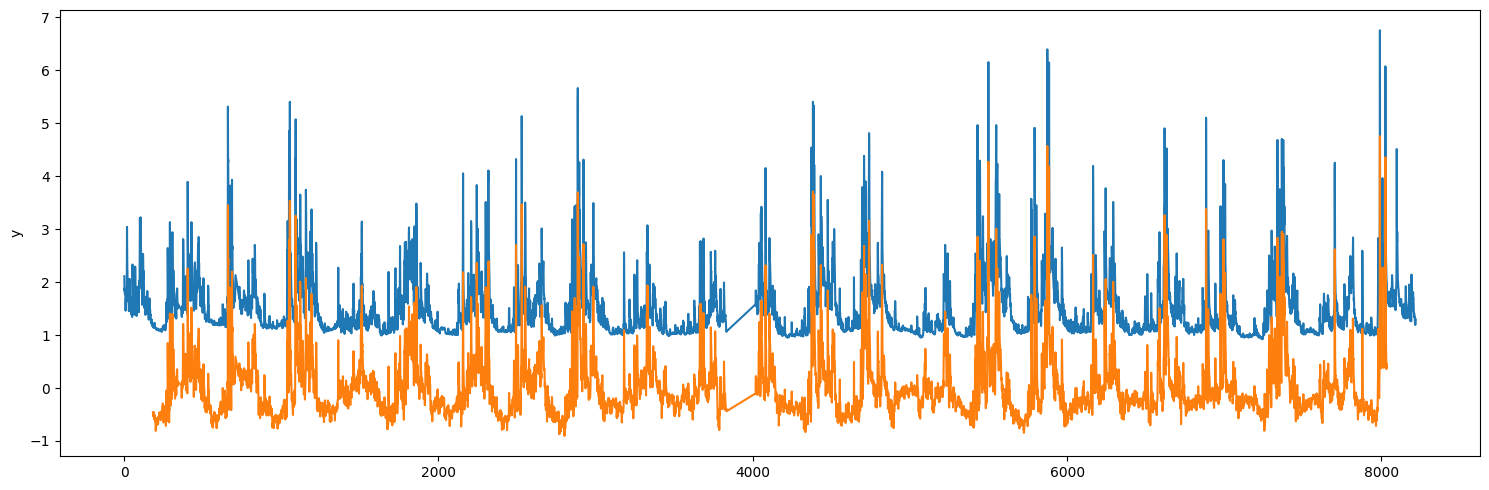

In [25]:
residual = decomposition.resid
fig, axis = plt.subplots(figsize = (15, 5))

sns.lineplot(data = df['y'])
sns.lineplot(data = residual)

plt.tight_layout()
plt.show()

### Análisis de autocorrelación

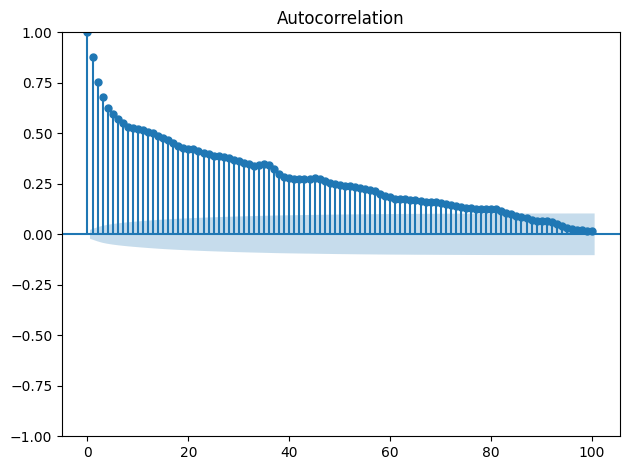

In [26]:
plot_acf(df['y'], lags=100)

plt.tight_layout()
plt.show()

## Entrenamiento del modelo

In [40]:
regresores = [
    'Rainfall_Le_Croci',
    'Rainfall_Cavallina',
    'Rainfall_S_Agata',
    'Rainfall_Mangona',
    'Rainfall_S_Piero',
    'Rainfall_Vernio',
    'Rainfall_Incisa',
    'Temperature_Firenze',
    'lag_1',
    'rainfall_1'
]

In [41]:
model = Prophet()

for reg in regresores:
    model.add_regressor(reg)
    
model.fit(df)

03:52:54 - cmdstanpy - INFO - Chain [1] start processing
03:52:55 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
future = model.make_future_dataframe(periods=30, freq='D')

for reg in regresores:
    last_known_value = df[reg].iloc[-1]
    future[reg] = last_known_value

forecast = model.predict(future)

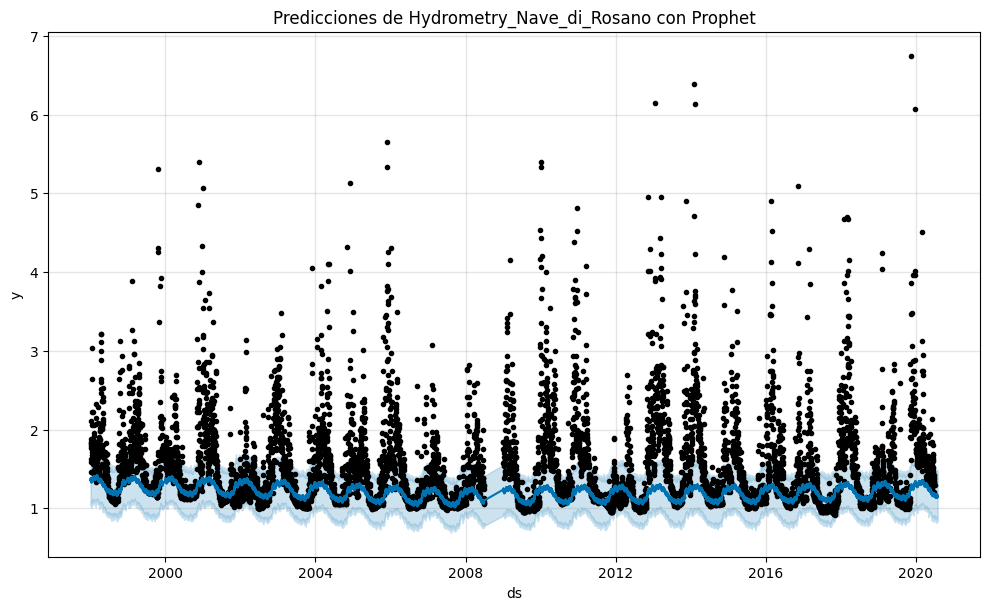

In [43]:
model.plot(forecast)
plt.title('Predicciones de Hydrometry_Nave_di_Rosano con Prophet')
plt.show()

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicciones en los datos de entrenamiento
y_pred = forecast['yhat'][:len(df)]
y_true = df['y']

# Calcular MAE y RMSE
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 0.3529142662176042
RMSE: 0.6202436349196478


In [45]:
from pickle import dump
with open('../models/modelo_prophet.pkl', 'wb') as file:
    dump(model, file)